# COMP4318/5318 Assignment 2: Image Classification

### Group number: A161  , SID1: 550077552 , SID2: 540561135

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [5]:
import numpy as np
import os
import time
import keras_tuner
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [8]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

X_train shape: (32000, 28, 28, 3)
y_train shape: (32000,)
Image shape: (28, 28, 3)
Pixel range: min = 0 , max = 255
First 5 labels: [7 3 4 2 6]


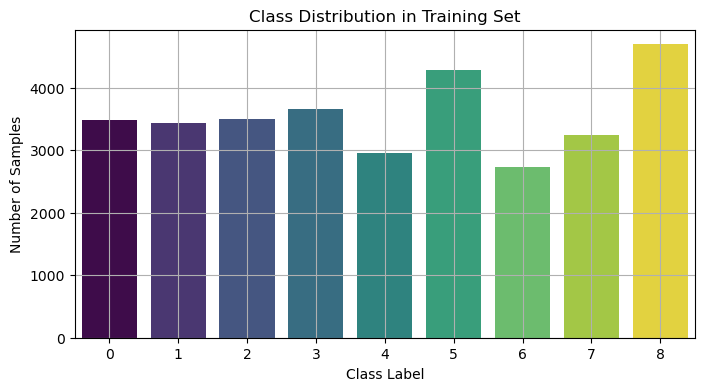

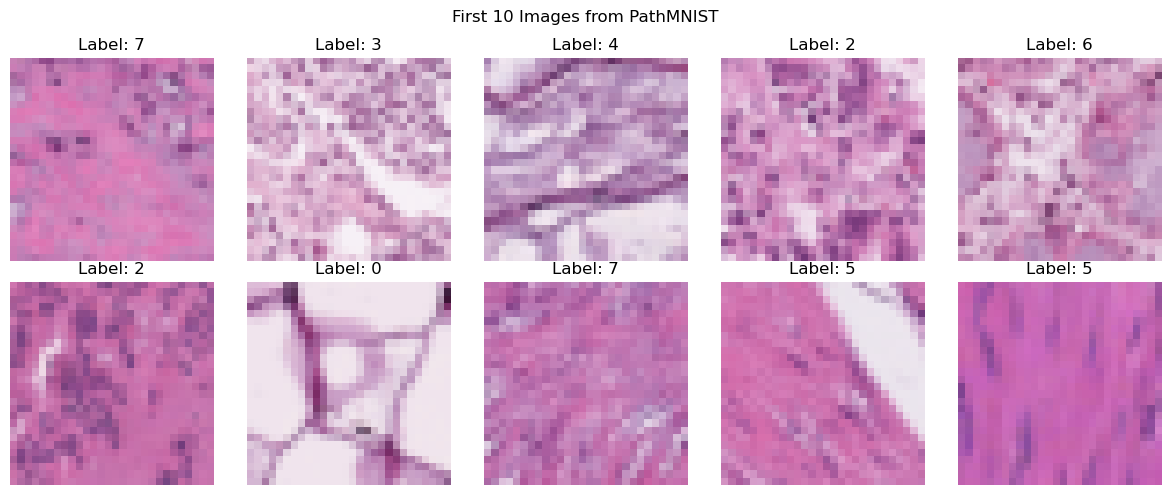

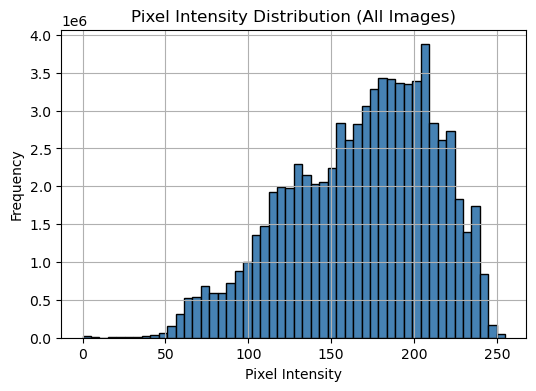

In [10]:
# Display dataset shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Check image shape and type
print("Image shape:", X_train[0].shape)
print("Pixel range: min =", X_train.min(), ", max =", X_train.max())

# Display first 5 labels
print("First 5 labels:", y_train[:5])

# Count the number of samples per class
class_counts = pd.Series(y_train).value_counts().sort_index()

# Convert to DataFrame for seaborn plotting
df_classes = pd.DataFrame({
    'Class': class_counts.index,
    'Count': class_counts.values
})

# Class distribution in the training set
plt.figure(figsize=(8, 4))
sns.barplot(data=df_classes, x='Class', y='Count', hue='Class', dodge=False, palette='viridis')
plt.legend([], [], frameon=False)  # hide the legend
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


# Plot first 10 sample images with labels
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("First 10 Images from PathMNIST")
plt.tight_layout()
plt.show()

# pixel intensity distribution
plt.figure(figsize=(6, 4))
plt.hist(X_train.flatten(), bins=50, color='steelblue', edgecolor='black')
plt.title("Pixel Intensity Distribution (All Images)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [13]:
# Preprocessing
X = np.load('Assignment2Data/X_train.npy').reshape(-1, 28*28*3) / 255.0
y = np.load('Assignment2Data/y_train.npy')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, random_state=42)

# Initial decision tree model (no tuning yet)
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

# Validation accuracy
y_pred = dt_model.predict(X_valid)
print(f"Decision Tree Validation Accuracy: {accuracy_score(y_valid, y_pred):.4f}")


KeyboardInterrupt: 

### Fully connected neural network

In [ ]:
# Reload image-shape data
X_full = np.load('Assignment2Data/X_train.npy') / 255.0
y_full = np.load('Assignment2Data/y_train.npy')
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.9, random_state=42)

# MLP model without tuning
mlp_model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(9, activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit model
history = mlp_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])

print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

### Convolutional neural network

In [ ]:
# CNN model without tuning
cnn_model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 3)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(9, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit model
history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])

print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [ ]:
# Stratified 5-fold cross-validation
cvFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=cvFold)

# Fit grid search on full dataset
print("Start grid searching...")
grid_search.fit(X, y)

# Report best parameters and score
print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Best criterion:", grid_search.best_params_['criterion'])
print("Best CV Score:", grid_search.best_score_)

In [ ]:
# 将搜索结果转为 DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# 查看前几行结果
print(results_df[['param_max_depth', 'param_criterion', 'mean_test_score']])

# 可视化：不同 max_depth 的准确率趋势
plt.figure(figsize=(8,5))
for criterion in param_grid['criterion']:
    subset = results_df[results_df['param_criterion'] == criterion]
    plt.plot(subset['param_max_depth'], subset['mean_test_score'], label=f'criterion={criterion}')

plt.xlabel('max_depth')
plt.ylabel('Mean CV Accuracy')
plt.title('Grid Search CV Accuracy vs. max_depth')
plt.legend()
plt.grid(True)
plt.show()

### Fully connected neural network

In [ ]:
def build_model(hp):
    model = keras.models.Sequential([
        keras.layers.Input(shape=[28, 28, 3]),
        keras.layers.Flatten()
    ])

    for i in range(1, 3):
        model.add(keras.layers.Dense(
            units=hp.Choice(f"units_{i}", [100, 200]),
            activation=hp.Choice("activation", ["relu", "sigmoid", "tanh"])
        ))

    model.add(keras.layers.Dense(9, activation="softmax"))
    model.compile(optimizer=keras.optimizers.SGD(
        learning_rate=hp.Choice("learning_rate", [0.1, 0.01, 0.001])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=24,
    executions_per_trial=1,
    directory="keras_tuning_results",
    project_name="assignment2_mlp"
)
tuner.search(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

In [ ]:
# 提取每个 trial 的超参数和最终验证准确率
results = []

for trial in tuner.oracle.trials.values():
    hp = trial.hyperparameters.values
    acc = trial.score  # 直接使用 score 替代 get
    results.append({
        'units_1': hp['units_1'],
        'units_2': hp['units_2'],
        'activation': hp['activation'],
        'learning_rate': hp['learning_rate'],
        'val_accuracy': acc
    })

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 显示表格（可选）
print(results_df)

# 可视化：不同 learning_rate 和 activation 的验证准确率趋势
plt.figure(figsize=(10, 6))

# 为每种 learning_rate 绘制趋势图
for lr in results_df['learning_rate'].unique():
    subset = results_df[results_df['learning_rate'] == lr]
    for activation in subset['activation'].unique():
        data = subset[subset['activation'] == activation]
        plt.plot(data['units_1'], data['val_accuracy'], label=f'lr={lr}, activation={activation}')

# 标题和标签
plt.title('Validation Accuracy vs. units_1 with different Learning Rates and Activations')
plt.xlabel('units_1')
plt.ylabel('Validation Accuracy')
plt.legend(title='Learning Rate and Activation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 输出表格：按 learning_rate 排序，显示不同超参数组合和对应的 val_accuracy
results_df_sorted = results_df.sort_values(by='learning_rate')

# 如果你需要将表格保存为 CSV 文件
# results_df_sorted.to_csv('hyperparameter_tuning_results.csv', index=False)

### Convolutional neural network

In [ ]:
# Re-load fresh, unflattened image data for CNN tuning
X = np.load('Assignment2Data/X_train.npy') / 255.0
y = np.load('Assignment2Data/y_train.npy')

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Confirm shape (should be 4D)
print("X_train shape:", X_train.shape)  # should be (num_samples, 28, 28, 3)
#  Now your tuning code is safe to run
def build_model_cnn(hp):
    model = keras.models.Sequential([
        keras.layers.Input(shape=[28, 28, 3]),
        keras.layers.Conv2D(
            filters=hp.Choice("filters_1", [32, 64, 128]),
            kernel_size=hp.Choice("kernel_size_1", [3, 5]),
            activation=hp.Choice("activation_1", ["relu", "tanh"])
        ),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(
            filters=hp.Choice("filters_2", [64, 128, 256]),
            kernel_size=hp.Choice("kernel_size_2", [3, 5]),
            activation=hp.Choice("activation_2", ["relu", "tanh"])
        ),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(hp.Float("dropout_rate", 0.3, 0.5, step=0.1)),
        keras.layers.Dense(9, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=hp.Choice("learning_rate", [0.1, 0.01, 0.001])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Run tuning
tuner = keras_tuner.RandomSearch(
    build_model_cnn,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=1,
    directory="keras_tuning_results",
    project_name="assignment2_cnn"
)

tuner.search(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

In [ ]:
# 提取每个 trial 的超参数和性能
results = []

for trial in tuner.oracle.trials.values():
    hp = trial.hyperparameters.values
    acc = trial.score  # 使用 trial.score 直接获取验证准确率
    results.append({
        'Filters 1': hp['filters_1'],
        'Kernel Size 1': hp['kernel_size_1'],
        'Activation 1': hp['activation_1'],
        'Filters 2': hp['filters_2'],
        'Kernel Size 2': hp['kernel_size_2'],
        'Activation 2': hp['activation_2'],
        'Dropout Rate': hp['dropout_rate'],
        'Learning Rate': hp['learning_rate'],
        'Validation Accuracy': acc
    })

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 查看前几行结果（可选）
print("Best Trials Hyperparameters and Validation Accuracy")
print(results_df)

# 样式化表格：突出显示验证准确率最好的几行
styled_df = results_df.style.highlight_max(subset='Validation Accuracy', color='lightgreen', axis=0)

# 显示样式化后的表格
styled_df

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

In [ ]:
# Use the best hyperparameters from grid search
best_depth = grid_search.best_params_['max_depth']
best_criterion = grid_search.best_params_['criterion']

# Train-test split (flattened data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Train the final Decision Tree model
final_dt = DecisionTreeClassifier(max_depth=best_depth, criterion=best_criterion, random_state=42)
final_dt.fit(X_train, y_train)

# Evaluate on the test set
accuracy = final_dt.score(X_test, y_test)
print(f"Decision Tree Final Model Test Accuracy: {accuracy:.4f}")


### Fully connected neural network

In [ ]:
# X_train and X_valid were already normalized earlier
X_test = np.load('Assignment2Data/X_test.npy') / 255.0
# Make sure input is flattened for MLP
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
# Final model trained on selected hyperparameters from keras-tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(2352,)))  # 使用扁平化输入
    model.add(keras.layers.Dense(hp.Int('units1', 64, 256, step=64), activation='relu'))
    model.add(keras.layers.Dense(hp.Int('units2', 32, 128, step=32), activation='relu'))
    model.add(keras.layers.Dense(9, activation='softmax'))  # 输出 9 类

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 获取最佳超参数并构建模型
best_hps = tuner.get_best_hyperparameters(1)[0]
model_nn = build_model(best_hps)

# Retrain on full training set (flattened)
history = model_nn.fit(X_train_flat, y_train, epochs=128, validation_data=(X_valid_flat, y_valid))

#plot the accuracies
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs for MLP')  # ← Add your title here
plt.show()


loss, accuracy = model_nn.evaluate(X_test_flat, y_test)
print(f"MLP Final Model Test Accuracy: {accuracy:.4f}")

# 输出最佳验证准确率和对应的 epoch
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

In [ ]:
# 确保数据被扁平化处理
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 获取最佳超参数
best_hps = tuner.get_best_hyperparameters(1)[0]

# 使用最佳超参数构建最终模型
def build_final_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(2352,)))  # 扁平化输入
    model.add(keras.layers.Dense(hp.Int('units1', 64, 256, step=64), activation='relu'))
    model.add(keras.layers.Dense(hp.Int('units2', 32, 128, step=32), activation='relu'))
    model.add(keras.layers.Dense(9, activation='softmax'))  # 输出 9 类

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 根据最佳超参数重新训练最终模型
model_nn = build_final_model(best_hps)

# 训练模型
history = model_nn.fit(X_train_flat, y_train, epochs=128, validation_data=(X_valid_flat, y_valid))

# 评估最终模型
loss, accuracy = model_nn.evaluate(X_test_flat, y_test)
print(f"Final Model Test Accuracy: {accuracy:.4f}")

# 绘制训练和验证准确率曲线
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs for Final Model')
plt.show()

# 输出最佳验证准确率和对应的 epoch
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

### Convolutional neural network

In [ ]:
# 加载数据并分割（注意，CNN 使用原始图像数据，不进行 reshape）
X_full = np.load('Assignment2Data/X_train.npy') / 255.0
y_full = np.load('Assignment2Data/y_train.npy')

# 不进行 flatten，保持原图像 shape: (N, 28, 28, 3)
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.9, random_state=42)

# 获取最佳超参数
best_hps = tuner.get_best_hyperparameters(1)[0]

# 构建 CNN 模型
model_cnn = build_model_cnn(best_hps)

# 训练模型
history = model_cnn.fit(X_train, y_train, epochs=128, validation_data=(X_valid, y_valid))

#plot the accuracies
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs for CNN')  # ← Add your title here
plt.show()


# 输出最佳验证准确率和对应的 epoch
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# 在测试集上评估
loss, accuracy = model_cnn.evaluate(X_valid, y_valid)
print(f"CNN Model Test Accuracy: {accuracy:.4f}")